# Heart Disease Report

The dataset used in this report is the Cleveland processed dataset which can be found in the data folder here: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

The objective of this study is to apply a classifer to the dataset to predict whether an individual has heart disease.

In [1]:
import seaborn as sns
from heart_disease import DataLoader, RandomForest

## Ingest and pre-process the data

The data is ingested and pre-processed with the following steps:
* Missing data is replaced. There are two missing values in the Thal column which is replaced with the label for normal. There are also 4 missing values in the Number of Major Vessels which are replaced with 0, which is the most common value in the column.
* Categorical features are converted into one-hot encoded features.
* All values are min-max normalised to be between 0 and 1.

Ideas for future improvement:
* Further test coverage
* Method to version the dataset

In [2]:
Loader = DataLoader()
dataset = Loader.dataset

2021-02-21 16:46:45 INFO Data Loader: Initialise Data Loader
2021-02-21 16:46:46 INFO Data Loader: Dataset loaded: 14 columns, 303 rows
2021-02-21 16:46:46 INFO Data Loader: 2 missing values in Thal, replaced with 3.0 (= normal).
2021-02-21 16:46:46 INFO Data Loader: 4 missing values in Number of Major Vessels, replaced with 0.0 (= mode).


In [3]:
dataset.describe(include="all")

,Age,Sex,Resting Blood Pressure,Cholestoral,Fasting Blood Sugar,Maximum Heart Rate,Exercise Induced Angina,ST Depression,Number of Major Vessels,Chest Pain Typical,...,Resting ECG Normal,Resting ECG Abnormal,Resting ECG Hypertrophy,Peak Exercise Slope Up,Peak Exercise Slope Flat,Peak Exercise Slope Down,Thal Normal,Thal Fixed Defect,Thal Reversable Defect,Heart Disease
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.529978,0.679868,0.355564,0.275555,0.148515,0.600055,0.326733,0.167678,0.221122,0.075908,...,0.498350,0.013201,0.488449,0.468647,0.462046,0.069307,0.554455,0.059406,0.386139,0.458746
std,0.188305,0.467299,0.166035,0.118212,0.356198,0.174618,0.469794,0.187270,0.311458,0.265288,...,0.500824,0.114325,0.500693,0.499842,0.499382,0.254395,0.497848,0.236774,0.487668,0.499120
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.395833,0.000000,0.245283,0.194064,0.000000,0.477099,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.562500,1.000000,0.339623,0.262557,0.000000,0.625954,0.000000,0.129032,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.666667,1.000000,0.433962,0.340183,0.000000,0.725191,1.000000,0.258065,0.333333,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Explore the data

Here a simple pairplot is used to visualise the dataset on a 2D scale. Only a few features are used in the plot below to reduce run time. From the plot we can see that some features such as Number of Major Vessels have noticeable split between heart disease and no heart disease.

Ideas for future improvement:
* Visualise dataset after applying PCA.
* Apply t-SNE to see whether there there is a clear split in a lower-dimensional latent space

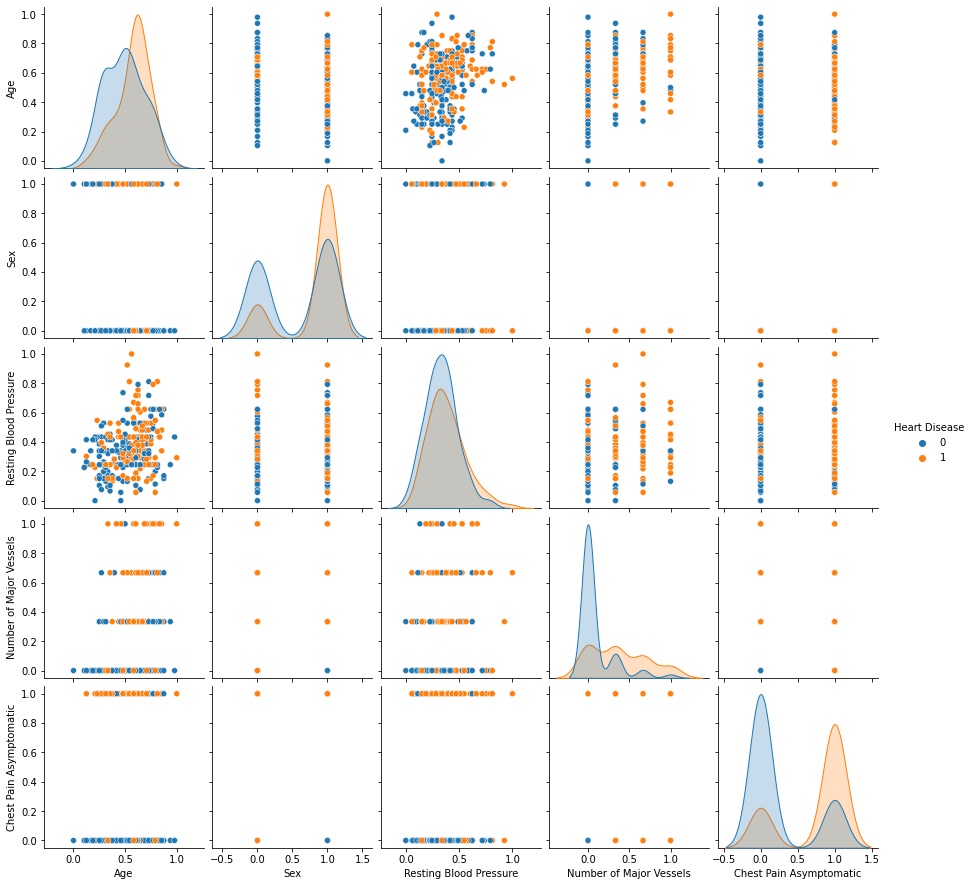

In [4]:
sns.pairplot(data=dataset, hue="Heart Disease", vars=["Age", "Sex", "Resting Blood Pressure", "Number of Major Vessels", "Chest Pain Asymptomatic"])

## Train Model

A random forest was chosen to train on this dataset. The reason for this is that a random forest is a good choice for a binary classification problem. Furthermore, the implementation of bagging means that the model is less likely to overfit and the variance of the model is typically lower. Feature importance is also easy to extract by looking at which features decrease the gini impurity the most.

In the cells below we train a random forest model on a single train/test split. Afterwards another train/test split is created, from which the train set is used to perform 10-fold cross validation with a parameter grid search. To reduce run time, the number of features searched over and the granularity of the grid search is small. 

Ideas for future improvements:
* Replace k-fold cross validation with leave-one-out. Due to the small nature of the dataset, it would be wise to use LOO to maximise the training set size and ensure a reliable result. A LOO was not implemented here to reduce run time.
* Expose more parameters of the random forest model and perform a larger grid search.
* Better test coverage

In [5]:
train_features, train_labels, test_features, test_labels = Loader.split_dataset(test_size=0.2, balance=True)

2021-02-21 16:46:53 INFO Data Loader: Training Features Shape: (270, 22)
2021-02-21 16:46:53 INFO Data Loader: Training Labels Shape: (270,)
2021-02-21 16:46:53 INFO Data Loader: Testing Features Shape: (61, 22)
2021-02-21 16:46:53 INFO Data Loader: Testing Labels Shape: (61,)


In [6]:
rf = RandomForest()
model, score = rf.train(train_features, train_labels, test_features, test_labels)

2021-02-21 16:46:53 INFO Random Forest: Initialise the Random Forest Class
2021-02-21 16:46:56 INFO Random Forest: Testing Set Accuracy: 0.869


Perform hyperparameter tuning by utilising K-fold Cross validation. For the sake of reducing the run-time of this notebook, the parameter search here is very minimal.

In [7]:
train, test = Loader.split_dataset(test_size=0.1, balance=False, split_labels=False)
params = {'n_estimators': [100, 250], 'max_depth': [3, None], 'max_features': [7, "auto"]}
param_scores = rf.perform_k_fold_cv(params, train, folds=10)

2021-02-21 16:46:56 INFO Data Loader: Training Shape: (272, 23)
2021-02-21 16:46:56 INFO Data Loader: Testing Shape: (31, 23)
2021-02-21 16:46:56 INFO Random Forest: Testing Set Accuracy: 0.821
2021-02-21 16:46:56 INFO Random Forest: Testing Set Accuracy: 0.750
2021-02-21 16:46:57 INFO Random Forest: Testing Set Accuracy: 0.778
2021-02-21 16:46:57 INFO Random Forest: Testing Set Accuracy: 0.778
2021-02-21 16:46:58 INFO Random Forest: Testing Set Accuracy: 0.815
2021-02-21 16:46:58 INFO Random Forest: Testing Set Accuracy: 0.815
2021-02-21 16:46:58 INFO Random Forest: Testing Set Accuracy: 0.741
2021-02-21 16:46:59 INFO Random Forest: Testing Set Accuracy: 0.815
2021-02-21 16:46:59 INFO Random Forest: Testing Set Accuracy: 0.815
2021-02-21 16:47:00 INFO Random Forest: Testing Set Accuracy: 0.852
2021-02-21 16:47:00 INFO Random Forest: 10-fold Result. n_estimators: 100, max_depth: 3, max_features: 7, accuracy: 0.80 +/- 0.03
2021-02-21 16:47:00 INFO Random Forest: Testing Set Accuracy: 0.

# Evaluate Model

The area under the receiver operating characteristic curve is used to evaluate the model. Further more, F-beta scores are calculated for a range of different values of beta. From the plots it can be seen that the random forest produces a very high AUC score. Furthermore, we can see by altering the threshold we can influence whether the model should prioritise recall or precision.

Ideas for future improvement:
* Compare the performance to a simple benchmark model (e.g logistic regression)
* Add regression tests
* Add further directional change tests. (If we perturb the input space we expect the result to increase/decrease. E.g. If we increase the age, we expect the outputted probability to increase). We want coverage across all our features.
* Add invariance tests. (A set of pertubations to the input space that we expect won't change the model's output).
* Pre-train model tests. (E.g. Model shape aligns with classes, the ranges are within our expectation etc.)

2021-02-21 16:47:45 INFO Random Forest: Testing Set Accuracy: 0.903


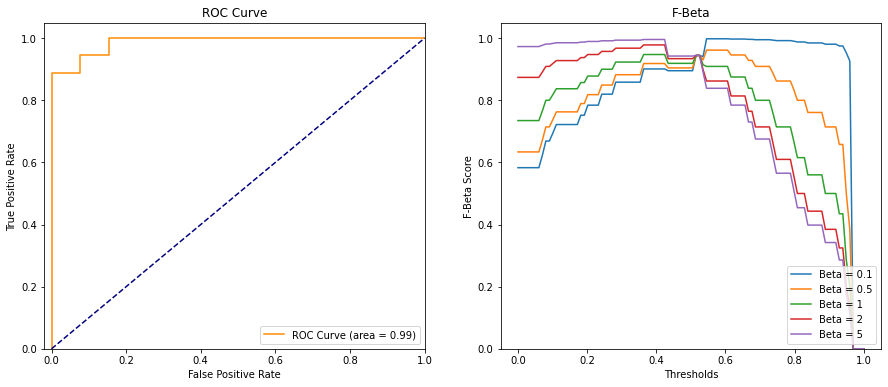

In [8]:
train_labels, train_features, feature_list = Loader.features_and_labels_to_numpy(train)
test_labels, test_features, _ = Loader.features_and_labels_to_numpy(test)

model, score = rf.train(train_features, train_labels, test_features, test_labels, n_estimators=250, max_depth=3, max_features='auto')
auc_score = rf.evaluate_model(model, test_features, test_labels, betas=[0.1, 0.5, 1, 2, 5])

## Feature Importance

Below all the features from the input space are plotted with their respective importance as evaluated from the random forest. It can be seen that the number of major vessels, asymptomatic chest pain and normal thal are the most decisive features to make a prediction.

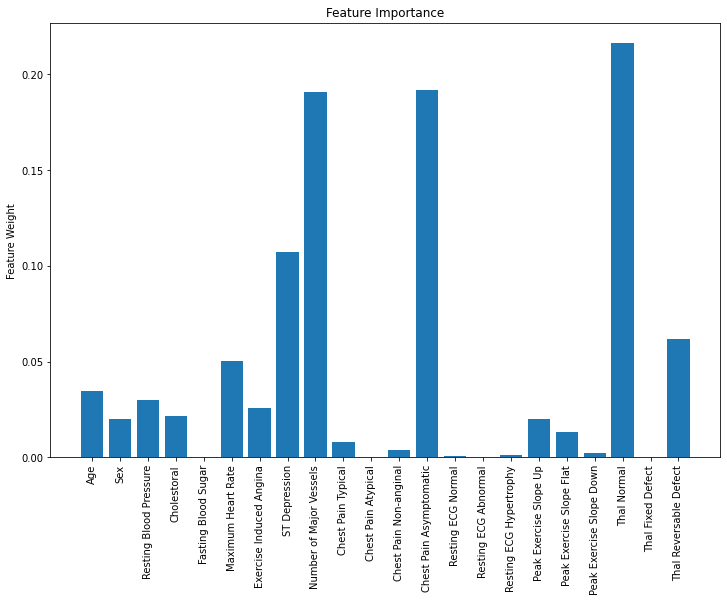

In [9]:
rf.plot_feature_importance(model, feature_list)